In [67]:
import numpy as np
import matplotlib.pyplot as plt

import crocoddyl
import pinocchio

import example_robot_data

from utils.plotting import plot_control_sequence, plot_state_trajectory, plot_cost, plot_convergence

In [68]:
dt = 1e-2  # Time step
T = 200  # Number of knots

In [69]:
print(T*dt)

2.0


In [70]:
# Loading RobotWrapper

robot = example_robot_data.load("double_pendulum")
print(type(robot))

for k in dir(robot):
    if k.startswith("__"):
        continue
    print(k)
# nv - dimension of the velocity space
# nq - dimension of the configuration space

<class 'pinocchio.robot_wrapper.RobotWrapper'>
BuildFromMJCF
BuildFromSDF
BuildFromURDF
Jcom
acceleration
acom
buildReducedRobot
centroidal
centroidalMap
centroidalMomentum
centroidalMomentumVariation
classicalAcceleration
collision_data
collision_model
com
computeFrameJacobian
computeJointJacobian
computeJointJacobians
data
display
displayCollisions
displayVisuals
forwardKinematics
frameAcceleration
frameClassicalAcceleration
framePlacement
frameVelocity
framesForwardKinematics
getFrameJacobian
getJointJacobian
getViewerNodeName
gravity
index
initFromMJCF
initFromSDF
initFromURDF
initViewer
loadViewerModel
mass
model
nle
nq
nv
placement
play
q0
rebuildData
setVisualizer
updateGeometryPlacements
urdf
v0
vcom
velocity
viewer
visual_data
visual_model
viz


In [71]:
# Wrapper contain robot model
robot_model = robot.model
collision_model = robot.collision_model
visual_model = robot.visual_model
for k in dir(robot_model):
    if k.startswith("__"):
        continue
    print(k)

addBodyFrame
addFrame
addJoint
addJointFrame
appendBodyToJoint
armature
cast
check
children
copy
createData
damping
effortLimit
existBodyName
existFrame
existJointName
frames
friction
getBodyId
getFrameId
getJointId
gravity
gravity981
hasConfigurationLimit
hasConfigurationLimitInTangent
idx_qs
idx_vExtendeds
idx_vs
inertias
jointPlacements
joints
loadFromBinary
loadFromString
loadFromText
loadFromXML
lowerPositionLimit
mimic_joint_supports
mimicked_joints
mimicking_joints
name
names
nbodies
nframes
njoints
nq
nqs
nv
nvExtended
nvExtendeds
nvs
parents
referenceConfigurations
rotorGearRatio
rotorInertia
saveToBinary
saveToString
saveToText
saveToXML
subtrees
supports
upperPositionLimit
velocityLimit


In [72]:
# Create a multibody state from the pinocchio model. - It provides mathematical operations
state = crocoddyl.StateMultibody(robot.model)
for k in dir(state):
    if k.startswith("__"):
        continue
    print(k)

Jdiff
Jintegrate
JintegrateTransport
copy
diff
has_limits
integrate
lb
ndx
nq
nv
nx
pinocchio
rand
ub
zero


In [73]:
# Creating actuation model -- custom modification. There is also `ActuationModelFull`
# Define the control signal to actuated joint mapping
class AcrobotActuationModel(crocoddyl.ActuationModelAbstract):
    def __init__(self, state):
        nu = 1  # Control dimension
        crocoddyl.ActuationModelAbstract.__init__(self, state, nu=nu)

    def calc(self, data, x, u):
        assert len(data.tau) == 2
        # Map the control dimensions to the joint torque
        data.tau[0] = 0
        data.tau[1] = u

    def calcDiff(self, data, x, u):
        # Specify the actuation jacobian
        data.dtau_du[0] = 0
        data.dtau_du[1] = 1


actuation_model = AcrobotActuationModel(state)
actuation_data = actuation_model.createData()

for k in dir(actuation_model):
    if k.startswith("__"):
        continue
    print(k)

print("----- Data ------")
for k in dir(actuation_data):
    if k.startswith("__"):
        continue
    print(k)

calc
calcDiff
commands
createData
nu
state
torqueTransform
----- Data ------
Mtau
copy
dtau_du
dtau_dx
tau
tau_set
u


In [74]:
# Check other option
full_actuation = crocoddyl.ActuationModelFull(state)
full_data = full_actuation.createData()
# Define some dummy state (x) and control (u) inputs
# Note: The dimension of x and u depends on the model
x_dummy = state.rand()

u_dummy = np.random.rand(actuation_model.nu)
u_full_dummy = np.random.rand(full_actuation.nu)

# 
# Inspection and Comparison

print("--- Inspecting Model Properties ---")
print(f"Robot nv (fixed-base): {robot.model.nv}")
print(f"Acrobot Model nu (control dim): {actuation_model.nu}")
print(f"Full Actuation Model nu (control dim): {full_actuation.nu}")
print("-" * 20)

print("\n--- Inspecting `calc()` Method Output (Torque Mapping) ---")
# Calculate for Acrobot Model
actuation_model.calc(actuation_data, x_dummy, u_dummy)
print(f"Acrobot control u: {u_dummy}")
print(f"Resulting torque tau for Acrobot: {actuation_data.tau.T}")
# Calculate for Full Model
full_actuation.calc(full_data, x_dummy, u_full_dummy)
print(f"\nFull Actuation control u: {u_full_dummy}")
print(f"Resulting torque tau for Full Model: {full_data.tau.T}")


print("\n--- Inspecting `calcDiff()` Method Output (Jacobian) ---")
# Calculate for Acrobot Model
actuation_model.calcDiff(actuation_data, x_dummy, u_dummy)
print(f"\nAcrobot Jacobian (dtau_du):\n{actuation_data.dtau_du}")
# Calculate for Full Model
full_actuation.calcDiff(full_data, x_dummy, u_full_dummy)
print(f"\nFull Actuation Jacobian (dtau_du):\n{full_data.dtau_du}")


--- Inspecting Model Properties ---
Robot nv (fixed-base): 2
Acrobot Model nu (control dim): 1
Full Actuation Model nu (control dim): 2
--------------------

--- Inspecting `calc()` Method Output (Torque Mapping) ---
Acrobot control u: [0.78120265]
Resulting torque tau for Acrobot: [0.         0.78120265]

Full Actuation control u: [0.70595145 0.14075936]
Resulting torque tau for Full Model: [0.70595145 0.14075936]

--- Inspecting `calcDiff()` Method Output (Jacobian) ---

Acrobot Jacobian (dtau_du):
[0. 1.]

Full Actuation Jacobian (dtau_du):
[[1. 0.]
 [0. 1.]]


/tmp/ipykernel_203174/4217413310.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.tau[1] = u


### Construction the Problem
So far we have robot_model, state, actuation_model with actuation_data.

The idea is to create 
```python
running_model = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuation_model, running_cost_model
    ),
    dt,
)
```

-   **`DifferentialActionModel` (the inner part):** For given current state `x` and control input `u`, it uses the robot's dynamics equations to calculate the resulting **joint acceleration `a`**.

-   **`IntegratedActionModelEuler` (the outer part):** It takes the acceleration from the differential model and integrates it over the time step `dt` to calculate the **next state (`x_next`)**.



In [75]:
# Defining cost function

# Initialization
running_cost_model = crocoddyl.CostModelSum(state, nu=actuation_model.nu)
terminal_cost_model = crocoddyl.CostModelSum(state, nu=actuation_model.nu)

# State residuals
xref = np.array([0, 0, 0, 0])  # Desired state
state_res = crocoddyl.ResidualModelState(state, xref=xref, nu=actuation_model.nu)
state_cost_model = crocoddyl.CostModelResidual(state, residual=state_res)  # creating cost
# Add it to the `running_cost_model`
running_cost_model.addCost("state_cost", cost=state_cost_model, weight=1e-5 / dt)
terminal_cost_model.addCost("state_cost", cost=state_cost_model, weight=1000)  # different weight

# Control residuals
control_res = crocoddyl.ResidualModelControl(state, nu=actuation_model.nu)
# Activation - It creates a specific penalty shape:
# Inside the bounds: The cost is zero.
# Outside the bounds: The cost is a quadratic function calculated as (value - boundary)^2.
bounds = crocoddyl.ActivationBounds(np.array([-1.0]), np.array([1.0]))  # limit control input
activation = crocoddyl.ActivationModelQuadraticBarrier(bounds)
control_cost = crocoddyl.CostModelResidual(state, activation=activation, residual=control_res)
# Add it to the `running_cost_model`
running_cost_model.addCost("control_cost", cost=control_cost, weight=1e-1 / dt)

# Finaly, create the action model
running_model = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuation_model, running_cost_model
    ),
    dt, # Calculate cost and simulate dinamics with timestep dt
)
terminal_model = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuation_model, terminal_cost_model
    ),
    0.0,  # dt=0 -- no dynamics are simulated, only cost is calculated
)

In [76]:
#print(cls.__doc__)
#help(crocoddyl.DifferentialActionModelFreeFwdDynamics)

crocoddyl.DifferentialActionModelFreeFwdDynamics?

Docstring:     
Differential action model for free forward dynamics in multibody systems.

This class implements a the dynamics using Articulate Body Algorithm (ABA),
or a custom implementation in case of system with armatures. If you want to
include the armature, you need to use set_armature(). On the other hand, the
stack of cost functions are implemented in CostModelSum().
Init docstring:
__init__( (object)self, (StateMultibody)state, (ActuationModelAbstract)actuation, (CostModelSum)costs [, (ConstraintModelManager)constraints]) -> None :
    Initialize the free forward-dynamics action model.
    
    :param state: multibody state
    :param actuation: abstract actuation model
    :param costs: stack of cost functions
    :param constraints: stack of constraint functions

    C++ signature :
        void __init__(_object*,std::shared_ptr<crocoddyl::StateMultibodyTpl<double> >,std::shared_ptr<crocoddyl::ActuationModelAbstractTpl<double> >,std::shared_ptr<crocoddyl::CostModelSumTpl<do

In [77]:
dir(running_cost_model)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__instance_size__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'active',
 'active_set',
 'addCost',
 'calc',
 'calcDiff',
 'changeCostStatus',
 'copy',
 'costs',
 'createData',
 'getCostStatus',
 'inactive',
 'inactive_set',
 'nr',
 'nr_total',
 'nu',
 'removeCost',
 'state']

In [78]:
# Print dimension of state and control
print(f"{state.nv} - Velocities dimension, {state.nq} - Configuration dimension, {state.nx} - State dimension")
print(f"{actuation_model.nu} - Control dimension")

2 - Velocities dimension, 2 - Configuration dimension, 4 - State dimension
1 - Control dimension


In [79]:
# Initial conditions
q0 = np.zeros((state.nq,))      # Inital joint configurations
q0[0] = np.pi / 2               # Down
v0 = np.zeros((state.nv,))      # Initial joint velocities
# Initial robot state
x0 = np.concatenate((q0, v0))


In [80]:
# Visualise it
from pinocchio.visualize import MeshcatVisualizer

viz = MeshcatVisualizer(model=robot_model, visual_model=visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()
viz.display(q0)

viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


In [81]:
problem = crocoddyl.ShootingProblem(x0, [running_model] * T, terminal_model)

In [82]:
# Sanity check

from MPPI.mppi import MPPI, MPPILogger

mppi_solver_test = MPPI(running_model, terminal_model, T, 100, 0.1, np.array([0.1, 0.1]))

# Test one rollout
u_test = [0.01 * np.ones((1,))] * T

x_test = problem.rollout(u_test)
cost_test = problem.calc(x_test, u_test)
x_test_mppi, cost_test_mppi = mppi_solver_test.rollout_trajectory(x0, np.array(u_test))

print(x_test.tolist() == x_test_mppi)
print(f"Cost ddp: {cost_test}, Cost mppi: {cost_test_mppi}")

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 

/tmp/ipykernel_203174/4217413310.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.tau[1] = u


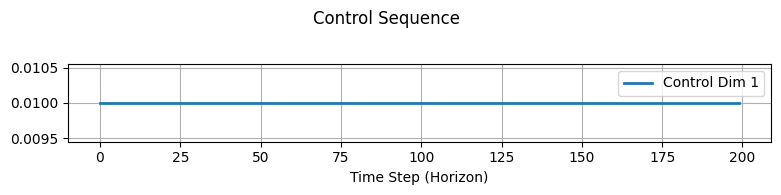

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

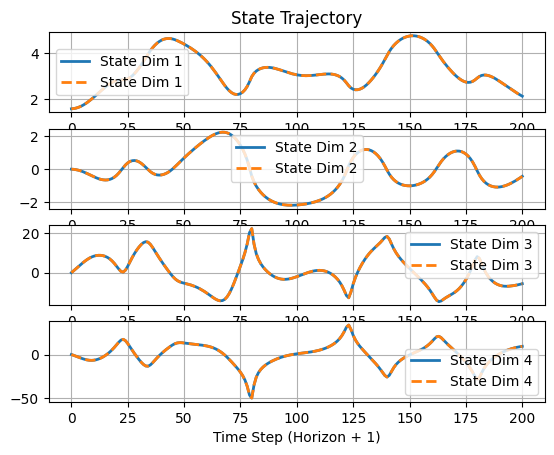

In [83]:
plot_control_sequence(np.array(u_test))

fig, axs = plt.subplots(state.nx, 1)
plot_state_trajectory(np.array(x_test.tolist()), axes=axs)
plot_state_trajectory(x_test_mppi, axes=axs, linestyles=["--"]*state.nx)

In [84]:
viz.display(q0)
viz.viewer.jupyter_cell()

In [85]:
viz.play([x[:robot.model.nq] for x in x_test], dt)

### Solving OCP

In [86]:
problem = crocoddyl.ShootingProblem(x0, [running_model] * T, terminal_model)

In [87]:
solver = crocoddyl.SolverFDDP(problem)
solver.setCallbacks([
    crocoddyl.CallbackLogger(),
    crocoddyl.CallbackVerbose()
])

U_nominal = np.zeros((T, actuation_model.nu))
u_init = list(U_nominal)
x_init = problem.rollout(u_init)

solver.solve(init_xs=x_init, init_us=u_init, maxiter=100)

# solver.solve()

iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  6.185e+03  0.000e+00  3.375e+04  6.749e+04  1.000e-09  1.000e-09  0.1250  0.000e+00  0.000e+00  0.000e+00  7.909e+03  2.756e+04  0.000e+00  0.000e+00
   1  5.582e+03  0.000e+00  6.184e+03  1.237e+04  1.000e-09  1.000e-09  0.0625  0.000e+00  0.000e+00  0.000e+00  7.489e+02  6.027e+02  0.000e+00  0.000e+00
   2  5.028e+03  0.000e+00  5.582e+03  1.116e+04  1.000e-09  1.000e-09  0.0625  0.000e+00  0.000e+00  0.000e+00  6.759e+02  5.539e+02  0.000e+00  0.000e+00
   3  4.464e+03  0.000e+00  5.028e+03  1.006e+04  1.000e-09  1.000e-09  0.1250  0.000e+00  0.000e+00  0.000e+00  1.178e+03  5.641e+02  0.000e+00  0.000e+00
   4  4.254e+03  0.000e+00  4.464e+03  8.927e+03  1.000e-09  1.000e-09  0.1250  0.000e+00  0.000e+00  0.000e+00  1.046e+03  2.097e+02  0.000e+00  0.000e+00
   5  2.798e+03  0.000e+00  4.254e+03  8.508e+03  1.000e-09  1.000e

/tmp/ipykernel_203174/4217413310.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.tau[1] = u


True

In [88]:
# Extracting the solution

log = solver.getCallbacks()[0]
xs = np.array(solver.xs.tolist())
us = np.array(solver.us.tolist())

In [89]:
# Visualisation
viz.display(q0)
viz.viewer.jupyter_cell()


In [90]:
viz.play([x[:robot.model.nq] for x in xs], dt)

In [91]:
log.costs[-1]

0.09265390413050593

<Axes: title={'center': 'Cost Over Iterations'}, xlabel='Iteration', ylabel='Cost Value'>

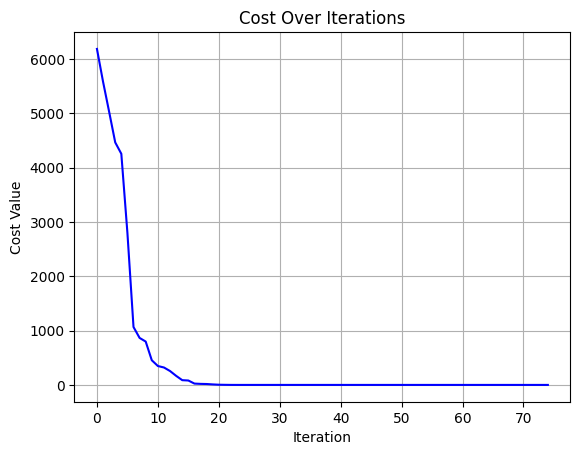

In [92]:
ax = plt.subplot()
plot_cost(log.costs, ax)
# ax.set_ylim(1e3, 1e4)


<Axes: title={'center': 'Convergence Rate'}, xlabel='Iteration (Change After)', ylabel='Change in Cost'>

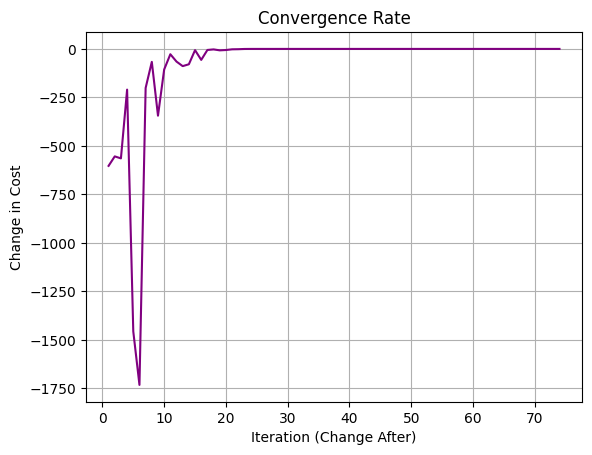

In [93]:
ax = plt.subplot()
plot_convergence(log.costs, ax)
# ax.set_ylim(-100, 1)

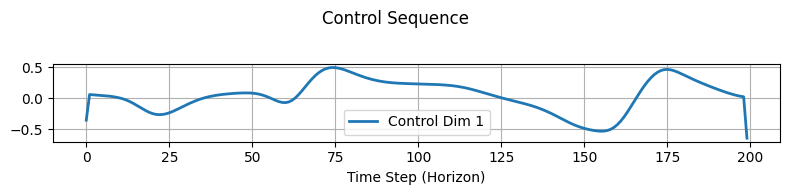

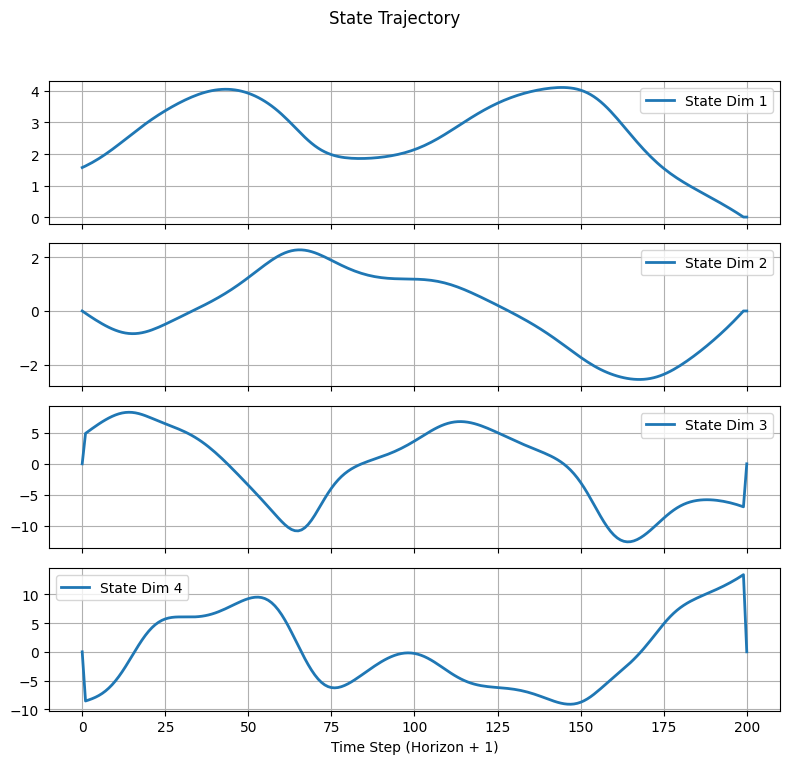

(<Figure size 800x800 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object))

In [94]:
plot_control_sequence(us)
plot_state_trajectory(xs)

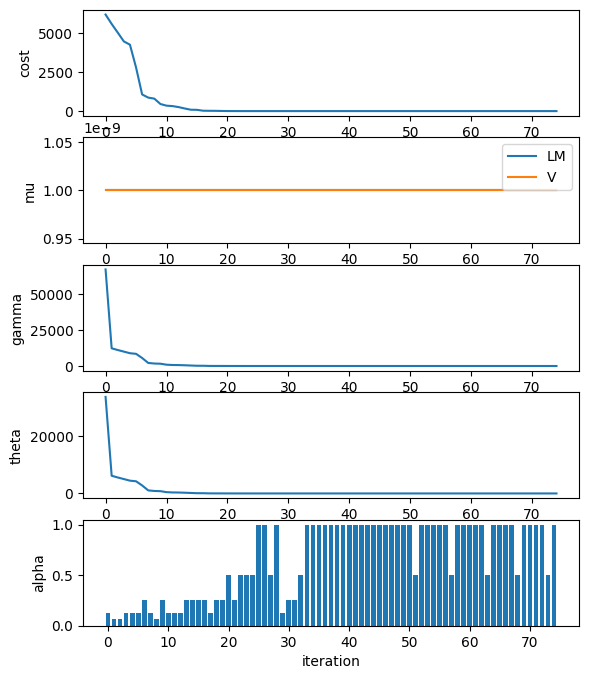

In [95]:
crocoddyl.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads, # gamma
    log.stops, # theta
    log.steps, # alpha
    show=False,
    figIndex=2,
)

In [96]:
num_samples = 100
lam = 1
sigma = np.ones(actuation_model.nu)
sigma[0] = 0.01
logger_mppi = MPPILogger(enable_logging=True, n_log=5)
mppi_solver = MPPI(running_model, terminal_model, T, num_samples=num_samples,
                   lambda_param=lam, noise_sigma=sigma, logger=logger_mppi)

us_mppi = mppi_solver.solve(x0, 500)
#us_mppi = mppi_solver.solve_receding_horizon(x0, T)

print("\nRolling out trajectory with optimal controls...")
xs_mppi, final_cost_mppi_ddp = mppi_solver.rollout_trajectory(x0, us_mppi)

logger_mppi.set_final_controls(us_mppi)
logger_mppi.set_final_state(xs_mppi)
# Store the final optimized nominal control sequence in the logger

print("\nRolling out trajectory with optimal controls...")
xs_mppi_ddp, final_cost_mppi_ddp = mppi_solver.rollout_trajectory(x0, us_mppi)
# Store the final optimized nominal control sequence in the logger
logger_mppi.set_final_controls(us_mppi)
logger_mppi.set_final_state(xs_mppi_ddp)

print(f"Final cost of optimal trajectory: {final_cost_mppi_ddp:.4f}")




/tmp/ipykernel_203174/4217413310.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.tau[1] = u


Iteration 1/500, Min Cost: 5166.7202, Mean Cost: 58117.0503
Iteration 2/500, Min Cost: 4167.2420, Mean Cost: 34652.4797
Iteration 3/500, Min Cost: 3377.8068, Mean Cost: 26771.6203
Iteration 4/500, Min Cost: 2882.6031, Mean Cost: 22784.8039
Iteration 5/500, Min Cost: 2658.2128, Mean Cost: 13022.4004
Iteration 6/500, Min Cost: 2463.3664, Mean Cost: 17470.9171
Iteration 7/500, Min Cost: 2291.6990, Mean Cost: 13550.6653
Iteration 8/500, Min Cost: 1793.9687, Mean Cost: 16192.7272
Iteration 9/500, Min Cost: 1701.3664, Mean Cost: 6504.1282
Iteration 10/500, Min Cost: 1554.6337, Mean Cost: 10980.6840
Iteration 11/500, Min Cost: 1464.6937, Mean Cost: 10676.7473
Iteration 12/500, Min Cost: 1391.7997, Mean Cost: 7946.2018
Iteration 13/500, Min Cost: 1292.3868, Mean Cost: 4862.2416
Iteration 14/500, Min Cost: 1216.7312, Mean Cost: 4900.9670
Iteration 15/500, Min Cost: 1218.7729, Mean Cost: 5410.3496
Iteration 16/500, Min Cost: 1194.5269, Mean Cost: 5611.8992
Iteration 17/500, Min Cost: 1262.6428, 

<Axes: title={'center': 'Cost Over Iterations'}, xlabel='Iteration', ylabel='Cost Value'>

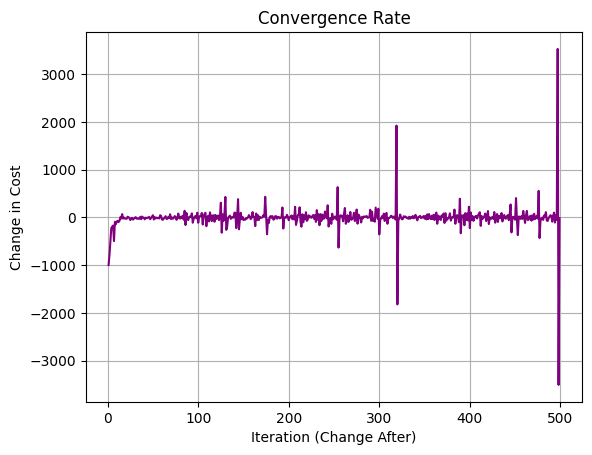

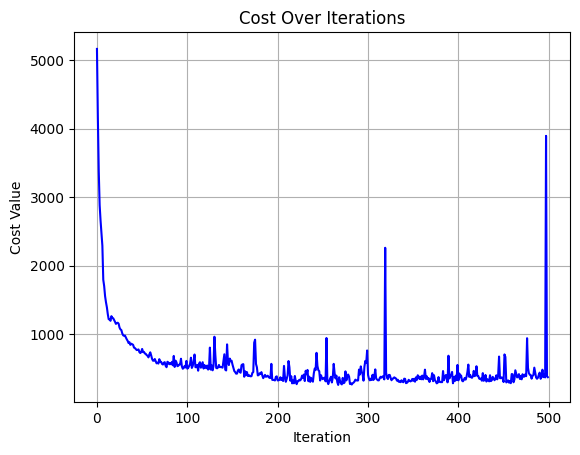

In [97]:
ax = plt.subplot()
plot_convergence(logger_mppi.total_cost_hist, ax)

plt.figure()
ax = plt.subplot()
plot_cost(logger_mppi.total_cost_hist, ax)
# ax.set_ylim(-100, 1)

In [ ]:
viz.display(q0)
viz.viewer.jupyter_cell()

In [99]:
viz.play([x[:robot.model.nq] for x in xs_mppi], dt)

In [101]:
from MPPI.mppi_ddp import MPPIDDP
logger_mppi_ddp = MPPILogger(True, 5)
num_samples = 100
lam = 1
sigma = np.ones(actuation_model.nu)
sigma[0] = 0.01
mppi_ddp_solver = MPPIDDP(running_model, terminal_model, T, num_samples=num_samples,
                   lambda_param=lam, noise_sigma=sigma, ddp_problem=problem, logger=logger_mppi_ddp)

us_mppi_ddp = mppi_ddp_solver.solve(x0, 60)
print("\nRolling out trajectory with optimal controls...")
xs_mppi_ddp, final_cost_mppi_ddp = mppi_ddp_solver.rollout_trajectory(x0, us_mppi_ddp)
# Store the final optimized nominal control sequence in the logger
logger_mppi_ddp.set_final_controls(us_mppi_ddp)
logger_mppi_ddp.set_final_state(xs_mppi_ddp)

print(f"Final cost of optimal trajectory: {final_cost_mppi_ddp:.4f}")

/tmp/ipykernel_203174/4217413310.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.tau[1] = u


Iteration 1/60, Min Cost: 4979.8807, Mean Cost: 45584.6476, DDP Cost: 6184.5599, DDP converged: False
Iteration 2/60, Min Cost: 3195.8652, Mean Cost: 31618.9824, DDP Cost: 3904.1016, DDP converged: False
Iteration 3/60, Min Cost: 2411.8674, Mean Cost: 27558.5745, DDP Cost: 3152.9181, DDP converged: False
Iteration 4/60, Min Cost: 2037.4160, Mean Cost: 18446.0746, DDP Cost: 2037.4160, DDP converged: False
Iteration 5/60, Min Cost: 1538.7391, Mean Cost: 7579.5050, DDP Cost: 1915.9484, DDP converged: False
Iteration 6/60, Min Cost: 1378.4954, Mean Cost: 8176.1732, DDP Cost: 1434.5296, DDP converged: False
Iteration 7/60, Min Cost: 1283.4764, Mean Cost: 6990.4137, DDP Cost: 1283.4764, DDP converged: False
Iteration 8/60, Min Cost: 1204.3997, Mean Cost: 5311.4311, DDP Cost: 1204.3997, DDP converged: False
Iteration 9/60, Min Cost: 932.5793, Mean Cost: 4904.3362, DDP Cost: 955.4039, DDP converged: False
Iteration 10/60, Min Cost: 823.6745, Mean Cost: 6624.1738, DDP Cost: 823.6745, DDP conver

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

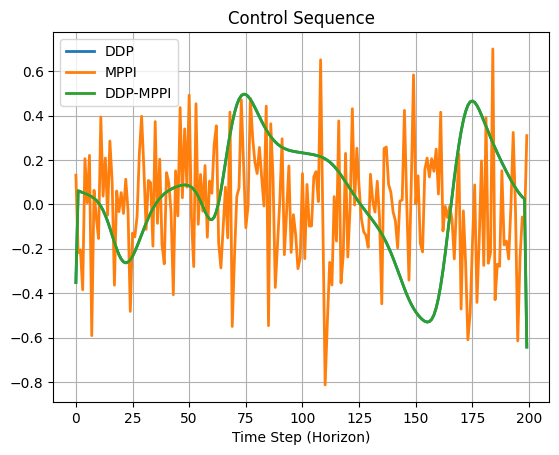

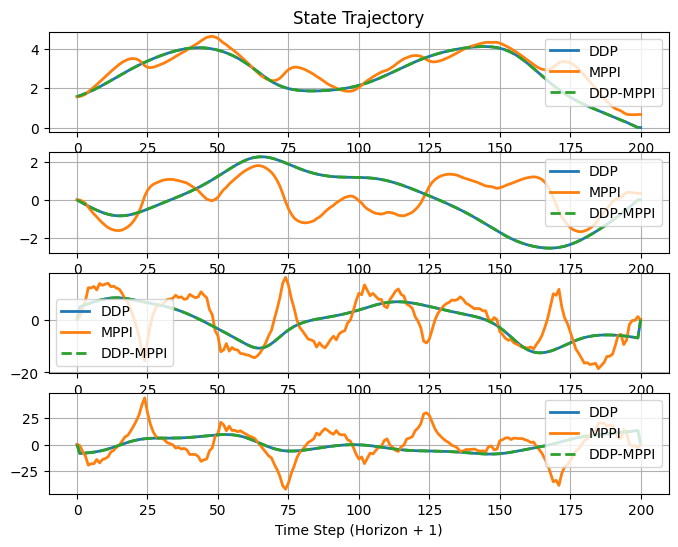

In [ ]:
nx = state.nx
nu = actuation_model.nu

fig, axs = plt.subplots(nu, 1)
plot_control_sequence(us, [axs], labels=["DDP"])
plot_control_sequence(us_mppi, [axs], labels=["MPPI"])
plot_control_sequence(us_mppi_ddp, [axs], labels=["DDP-MPPI"], linestyles="--")

fig, axs = plt.subplots(nx, 1, figsize=(8, 6))
plot_state_trajectory(xs, axs, labels=["DDP"]*nx)
plot_state_trajectory(xs_mppi, axs, labels=["MPPI"]*nx)
plot_state_trajectory(xs_mppi_ddp, axs, labels=["DDP-MPPI"]*nx, linestyles=["--"]*nx)

(0.0, 2000.0)

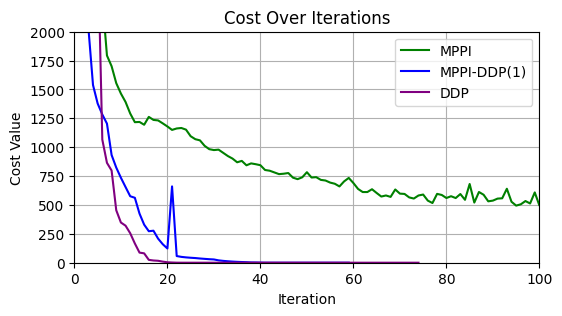

In [105]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]
ddp_costs = log.costs
# Plot each cost history on the same subplot
plot_cost(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_cost(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_cost(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(0, 2000)

(-100.0, 10.0)

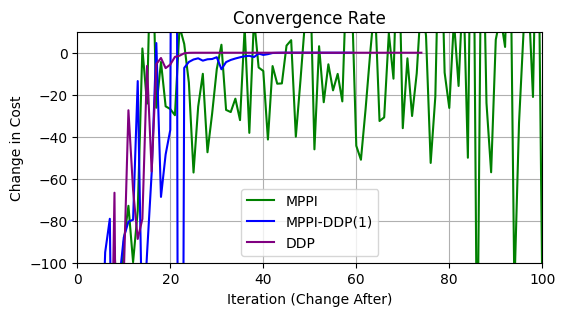

In [109]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]
ddp_costs = log.costs
# Plot each cost history on the same subplot
plot_convergence(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_convergence(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_convergence(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(-100, 10)